# Analiza danych parku rozrywki AiBtcQuantLandia
## 1. Wstęp

Raport przedstawia analizę danych zgromadzonych w relacyjnej bazie danych
parku rozrywki **AiBtcQuantLandia**.

Celem raportu jest:
- analiza popularności atrakcji,
- porównanie kosztów i przychodów działalności,
- ocena liczby odwiedzających na przestrzeni czasu.

**Wszystkie wyniki, wykresy oraz wnioski są generowane automatycznie**
na podstawie aktualnego stanu bazy danych.  
Zmiana danych wejściowych powoduje automatyczną aktualizację raportu.

## 2. Połączenie z bazą
Analiza opiera się na danych przechowywanych w relacyjnej bazie danych MySQL.


In [23]:
import pandas as pd
import matplotlib.pyplot as plt
from budowa import Baza 

try:
    baza = Baza()
    print("Pomyślnie połączono z bazą AiBtcQuantLandia.")
except Exception as e:
    print(f"Błąd połączenia: {e}")


Pomyślnie połączono z bazą AiBtcQuantLandia.


## 3. Analiza danych 
### a) Która atrakcja przynosi najwiekszy przychód?

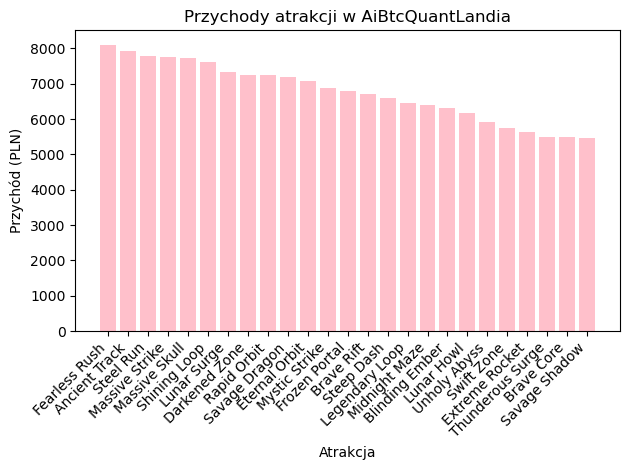

In [24]:

query = """
SELECT a.attraction_name, SUM(p.amount) AS przychod
FROM attractions a
JOIN prices pr ON a.attraction_id = pr.attraction_id
JOIN payment_ticket pt ON pr.ticket_id = pt.ticket_id
JOIN payments p ON pt.payment_id = p.payment_id
GROUP BY a.attraction_name
ORDER BY przychod DESC
"""
baza.cursor.execute(query)
rows = baza.cursor.fetchall()  #tu mamy krotki (nazwa, kwota)...

attractions = [r[0] for r in rows] #a tu juz nie
revenues = [r[1] for r in rows]

import matplotlib.pyplot as plt

plt.bar(attractions, revenues, color='pink')
plt.xlabel("Atrakcja")
plt.ylabel("Przychód (PLN)")
plt.title("Przychody atrakcji w AiBtcQuantLandia")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#print(f"Najwięcej zarabia atrakcja: .")

### b) Analiza bezpieczeństwa: Czy atrakcje są niebezpieczne?

W tej sekcji sprawdzamy, które atrakcje generują najwięcej incydentów i jak poważne one są.
Na tej podstawie system zarekomenduje:
- **Poprawę bezpieczeństwa** (gdy awarie są ryzykowne dla zdrowia).
- **Zwiększenie ubezpieczenia** (gdy awarie są częste, ale mało groźne).

In [ ]:
query_safety = """
SELECT 
    a.attraction_name,
    COUNT(i.incident_id) AS liczba_wypadkow,
    AVG(it.risk_level) AS srednie_ryzyko
FROM attractions a
JOIN incidents i ON a.attraction_id = i.attraction_id
JOIN incident_type it ON i.incident_type_id = it.incident_type_id
GROUP BY a.attraction_name
HAVING liczba_wypadkow > 0
ORDER BY srednie_ryzyko DESC, liczba_wypadkow DESC
LIMIT 10
"""

try:
    baza.cursor.execute(query_safety)
    rows = baza.cursor.fetchall()
    columns = [col[0] for col in baza.cursor.description]
    
    df_safety = pd.DataFrame(rows, columns=columns)
    df_safety['srednie_ryzyko'] = df_safety['srednie_ryzyko'].astype(float)

except Exception as e:
    print(f"Wystąpił błąd SQL: {e}")
    df_safety = pd.DataFrame()


if df_safety.empty:
    print("Brak danych o incydentach do analizy.")
else:
    plt.figure(figsize=(10, 6))

    kolory = ['red' if x > 3.5 else 'orange' for x in df_safety['srednie_ryzyko']]

    plt.bar(df_safety['attraction_name'], df_safety['srednie_ryzyko'], color=kolory)

    plt.xlabel("Nazwa Atrakcji")
    plt.ylabel("Średni poziom ryzyka (1-5)")
    plt.title("Top 10 Atrakcji o najwyższym ryzyku")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    print("WNIOSKI")
    najgorsza = df_safety.iloc[0]
    print(f"Najbardziej problematyczna: {najgorsza['attraction_name']} (Incydenty: {najgorsza['liczba_wypadkow']})")

    if najgorsza['srednie_ryzyko'] > 3.5:
        print(" DECYZJA: Atrakcja jest bardzo niebezpieczna. Zalecana natychmiastowa naprawa systemów bezpieczeństwa.")
    else:
        print(" DECYZJA: Ryzyko umiarkowane. Zalecane zwiększenie pakietu ubezpieczenia OC.")

### c) Analiza wieku klientów: Kto odwiedza park najczęściej?

Analiza struktury wiekowej gości pozwala dostosować ofertę marketingową.
Sprawdzamy rozkład wieku zarejestrowanych gości, aby odpowiedzieć na pytania:
- Czy park przyciąga głównie młodzież, czy rodziny z dziećmi?
- Do kogo kierować reklamy?

In [ ]:
query_age = "SELECT birth_date FROM guests"

try:
    baza.cursor.execute(query_age)
    rows = baza.cursor.fetchall()
    df_age = pd.DataFrame(rows, columns=['birth_date'])

    df_age['birth_date'] = pd.to_datetime(df_age['birth_date'])
    now = pd.Timestamp.now()
    
    df_age['wiek'] = (now - df_age['birth_date']).dt.days / 365.25

    plt.figure(figsize=(10, 6))
    n, bins, patches = plt.hist(df_age['wiek'], bins=range(0, 80, 5), color='skyblue', edgecolor='black', alpha=0.7)

    plt.xlabel("Wiek (lata)")
    plt.ylabel("Liczba gości")
    plt.title("Struktura wiekowa gości AiBtcQuantLandia")
    plt.grid(axis='y', alpha=0.5)
    plt.xticks(bins)
    plt.show()

    srednia_wieku = df_age['wiek'].mean()
    dominujaca_grupa_idx = n.argmax()
    dominujaca_grupa_start = bins[dominujaca_grupa_idx]
    dominujaca_grupa_end = bins[dominujaca_grupa_idx+1]

    print("--- PROFIL KLIENTA ---")
    print(f"Średnia wieku gościa: {round(srednia_wieku, 0)} lat.")
    print(f"Najliczniejsza grupa wiekowa: {int(dominujaca_grupa_start)}-{int(dominujaca_grupa_end)} lat.")
    
    if dominujaca_grupa_start < 20:
        print("WNIOSEK: Park przyciąga głównie dzieci i młodzież. Zalecane kampanie na TikToku i Instagramie.")
    elif dominujaca_grupa_start < 30:
        print("WNIOSEK: Główni klienci to młodzi dorośli. Warto promować atrakcje ekstremalne.")
    else:
        print("WNIOSEK: Park odwiedzają całe rodziny. Warto promować bilety rodzinne i strefy gastronomiczne.")

except Exception as e:
    print(f"Błąd analizy wieku: {e}")

### d) Analiza techniczna: Koszty napraw i awaryjność

Nie każda awaria kosztuje tyle samo. Czasem naprawa drobnej usterki to grosze, a innym razem jedna poważna awaria pochłania ogromne kwoty.
W tej analizie sprawdzamy, na które atrakcje park wydaje najwięcej pieniędzy w serwisie (naprawy, części i robocizna).

In [ ]:
query_maintenance = """
SELECT 
    a.attraction_name,
    COUNT(m.malfunction_id) as liczba_awarii,
    SUM(m.fix_cost) as laczny_koszt_napraw
FROM attractions a
JOIN malfunctions m ON a.attraction_id = m.attraction_id
GROUP BY a.attraction_name
ORDER BY laczny_koszt_napraw DESC
LIMIT 10
"""

try:
    baza.cursor.execute(query_maintenance)
    rows = baza.cursor.fetchall()
    df_maint = pd.DataFrame(rows, columns=['attraction_name', 'liczba_awarii', 'koszt'])

    df_maint['koszt'] = df_maint['koszt'].astype(float)

    if df_maint.empty:
        print("Brak danych o naprawach. Park działa idealnie!")
    else:
        plt.figure(figsize=(10, 6))
        df_plot = df_maint.sort_values('koszt', ascending=True)
        
        plt.barh(df_plot['attraction_name'], df_plot['koszt'], color='#d62728')

        plt.xlabel("Łączny koszt napraw (PLN)")
        plt.title("Top 10 najdroższych w utrzymaniu atrakcji")
        plt.grid(axis='x', linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()

        top_fail = df_maint.iloc[0]
        avg_cost = df_maint['koszt'].mean()

        print("RAPORT SERWISOWY:")
        print(f"Najdroższa atrakcja w naprawach: {top_fail['attraction_name']}")
        print(f"Koszt całkowity: {top_fail['koszt']:,.2f} PLN (przy {top_fail['liczba_awarii']} awariach)")

        if top_fail['koszt'] > 2 * avg_cost:
            print("REKOMENDACJA: Atrakcja generuje krytyczne obciążenie budżetowe. Należy rozważyć jej zamknięcie lub gruntowną modernizację.")
        else:
            print("REKOMENDACJA: Koszty są wysokie, ale w normie dla tego typu urządzeń. Należy monitorować stan techniczny.")

except Exception as e:
    print(f"Błąd analizy kosztów: {e}")